# **Pre-Processing**
In diesem Skript werden die Rohdaten zur auswertung vorbereitet. Dabei werden Ausreiser und falsche Messwerte entfernt, verschiedene Klassifikationen durchgeführt und aus den entstandenen Daten eine neue Datenbank erstellt.

In [2]:
import RomansThesis

ImportError: cannot import name 'style' from 'src' (c:\Users\Roman\workspace\ModellingOccupantBehavior\src\__init__.py)

In [1]:
from src import RomansThesis
dir(RomansThesis)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'toolbox']

In [3]:
### Jupyter-Einstellungen
%load_ext autoreload
%autoreload 2

from setuptools import find_packages
find_packages('src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


['toolbox']

## Importe

In [10]:
### Jupyter-Einstellungen
%load_ext autoreload
%autoreload 2
### Python-Packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import locale
locale.setlocale(locale.LC_ALL, 'de_DE.UTF-8')

from pandas import IndexSlice as IDX
import pandas as pd
import numpy as np

import src.preprocessing as pp
import src.style as style
import src.toolbox as tb

from src.preprocessing import getData
from src.style import BUID, ROOMS, APPS, cleanBuiAppAxis

### Datenbank-Import
try:
    from src.preprocessing import DB, AMB, IND
except ImportError:
    pp.getDB()
    from src.preprocessing import DB, AMB, IND

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Lade WetterDB...
Lade Raumklima...
Lade gespeicherte Datenbank...                                                                


# Pre-Processing

In [4]:
df = AMB.T_amb.groupby(tb.utils.getSeason(AMB.index)).agg(['mean', 'median', 'std']).reindex(['Übergang']).rename_axis('Jahreszeit')
df = pd.concat( (df, AMB.T_amb.groupby(tb.utils.getSeason(AMB.index, übergang=False)).agg(['mean', 'median', 'std']).reindex([ 'Frühling', 'Herbst']).rename_axis('Jahreszeit')))
(df.style
.format(formatter='{:.1f} °C', escape='latex')
.format(formatter='{:.1f} K', escape='latex', subset=['std'])
# .to_latex(
#     './LaTex/tbls/tbl_pp_vgl_seasons.tex',
#     caption='Vergleich der des Mittelwerts, des Medians und der Standardabweichung der Außenlufttemperatur für die Klassifikation nach Frühlung und Herbst sowie der Zusamenfassung als Übergang.',
#     clines="skip-last;data",
#     siunitx=True,
#     hrules=True,
#     position= '!ht',
#     position_float="centering",
#     multicol_align="|c|",
#     label='tbl:SeasonsTambVgl')
)
df

,mean,median,std
Jahreszeit,,,
Übergang,9.039516,8.5,7.292989
Frühling,9.141198,8.9,7.389955
Herbst,8.845976,7.7,7.100777


## Einzugsdaten

In [5]:
df = pd.read_csv('data/eb_Einzugsdaten.csv', sep=';', index_col=0, header=[0,1]).stack([0,1]).dropna().reset_index().drop(0,axis=1).set_axis(['Einzugsdatum', 'Haus', 'Wohnung'], axis=1).set_index(['Haus', 'Wohnung']).sort_index()
df.Einzugsdatum = df.Einzugsdatum.apply(lambda x: pd.to_datetime(x, dayfirst=True))
df = df.unstack(0).rename(columns=BUID, index=APPS).droplevel(0, axis=1)
(df.style
    .format(lambda x: x.strftime("%d. %b '%y"))
    # .to_latex('LaTex/tbls/tbl_pp_Einzugsdaten.tex',
    #         caption='Einzugsdaten der Mieter*Innen und Beginn der Messdaten', 
    #         siunitx=True, 
    #         hrules=True, 
    #         position= '!ht',
    #         position_float="centering",
    #         label='Einzugsdaten',
    #         )
)
df

Haus,Leichtbeton,Massivholz,Mauerwerk
Wohnung,,,
Nord,2020-07-01,2021-05-01,2021-04-01
Ost,2020-07-01,2020-10-01,2020-10-01
Süd,2020-07-01,2021-06-01,2021-03-01


## Korrekturfaktoren

In [20]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from src.preprocessing import getIND

In [7]:
plot = True
if 'IND' not in globals():
    getIND()
Tair = IND.loc[:,pd.IndexSlice[:,'O', 'SWK',:]].filter(like='Tair').filter(like='trh').rename_axis(['bui', 'app', 'room', 'value'], axis=1).stack([0,1,2]).reset_index().rename(columns={'m_trh1_Tair (°C)': 'trh_ref', 'm_trh_Tair (°C)':'trh', 'm_trh1_RH (%)': 'trh_ref', 'm_trh_RH (%)':'trh'})
rH = IND.loc[:,pd.IndexSlice[:,'O', 'SWK',:]].filter(like='RH').filter(like='trh').rename_axis(['bui', 'app', 'room', 'value'], axis=1).stack([0,1,2]).reset_index().rename(columns={'m_trh1_Tair (°C)': 'trh_ref', 'm_trh_Tair (°C)':'trh', 'm_trh1_RH (%)': 'trh_ref', 'm_trh_RH (%)':'trh'})
gabs = tb.comf.g_abs(Tair.set_index(['Datetime', 'bui', 'app', 'room']), rH.set_index(['Datetime', 'bui', 'app', 'room']))
coefs = {}
data = gabs
for bui, df in data.groupby('bui'):
    df.dropna(inplace=True)
    X = df['trh'].to_numpy().reshape(-1, 1)
    y = df['trh_ref'].to_numpy().reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    regr = linear_model.RidgeCV().fit(X_train, y_train)
    coefs[('gabs', bui)] = regr.coef_[0][0]

    if plot:
        y_pred = regr.predict(X_test)
        fig, ax = plt.subplots()
        ax.set_title(f'Korrekturfaktor gabs {BUID[bui]}')
        ax.scatter(X_test, y_test, color="black", s=.5, label='beobachtete Werte')
        ax.plot(X_test, y_pred, color="blue", linewidth=1, label='Regressionsgerade')
        text = '\n'.join([
            f"Mittleres Residuenquadrat: {mean_squared_error(y_test, y_pred):.2n}",
            f"Bestimmtheitsmaß $R^2$: {r2_score(y_test, y_pred):.2n}",
            f"Ermittelter Faktor: {regr.coef_[0][0]:.3n}"])
        ax.grid()
        ax.set(ylabel='Sensor am Netzwerk $[\si{\gram\per\kilo\gram}]$', xlabel='Referenzsensor $[\si{\gram\per\kilo\gram}]$')
        ax.text(0.03,1, text, transform=ax.transAxes, ha='left', va='top')
        ax.legend(ncol=2, frameon=False, bbox_to_anchor = (1, .98), loc='lower right')
        fig.tight_layout()

exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...


,Rh,Tair
LB,-4.94,-0.05
MH,-3.68,0.07
MW,-12.76,-0.40


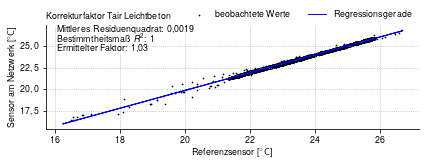

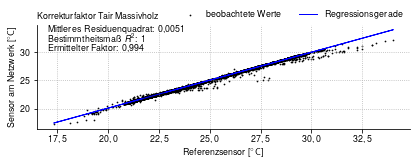

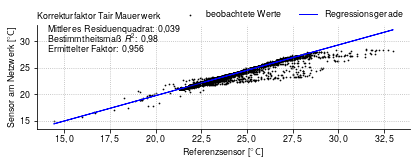

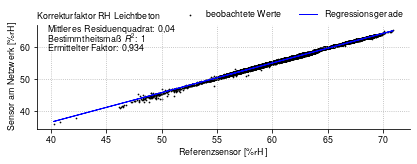

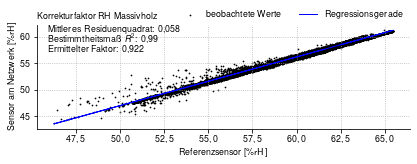

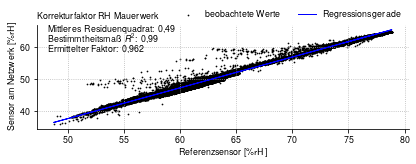

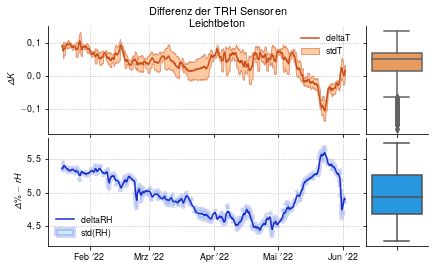

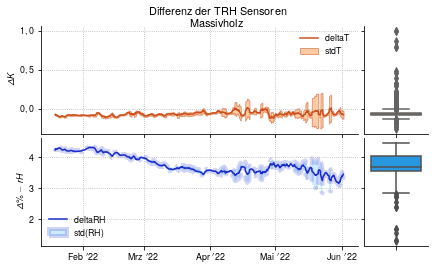

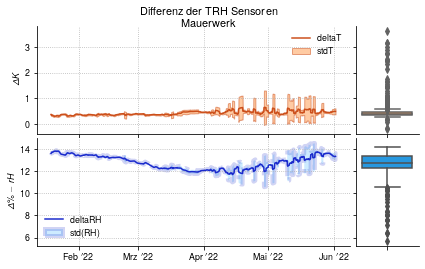

In [11]:
pp.updateKorrektur_lin(toTex=True)
pp.updateKorrektur_fix(toTex=False)

## Ausreißer Korrektur

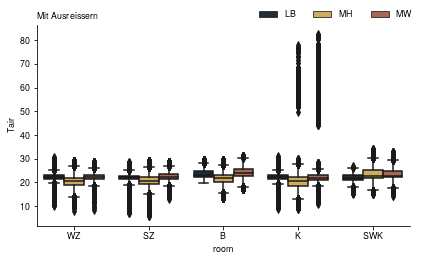

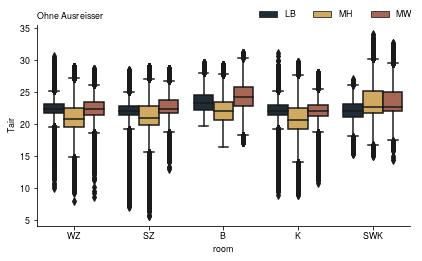

In [14]:
fig, ax = plt.subplots(1,1, sharex=True)
TAIR = IND[IND.columns[IND.columns.get_level_values(3).str.contains('trh_Tair')]].droplevel(3,axis=1).rename_axis(['bui', 'app', 'room'], axis=1).melt(value_name='Tair')
sns.boxplot(data=TAIR, x = 'room', y='Tair', hue='bui', order=ROOMS, hue_order=BUID, palette=style.CLRS)
ax.set(title='Mit Ausreissern')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

fig, ax = plt.subplots(1,1, sharex=True)
sns.boxplot(data=DB.loc[:,IDX[:,:,:,'Tair']].stack([0,1,2]).reset_index(), x = 'room', y='Tair', hue='bui', order=ROOMS, hue_order=BUID, palette=style.CLRS)
ax.set(title='Ohne Ausreisser')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()


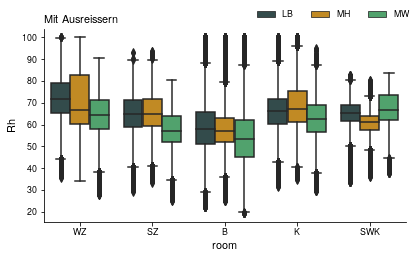

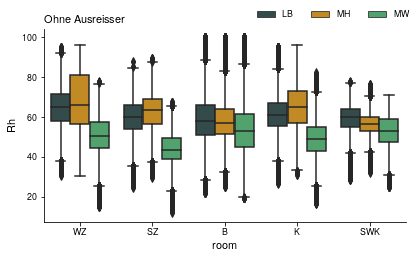

In [9]:
fig, ax = plt.subplots()

RH = IND[IND.columns[IND.columns.get_level_values(3).str.contains('trh_RH')]].droplevel(3,axis=1).rename_axis(['bui', 'app', 'room'], axis=1).melt(value_name='Rh')
sns.boxplot(data=RH, x = 'room', y='Rh', hue='bui', order=ROOMS, hue_order=BUID, palette=style.CLRS)
ax.set(title='Mit Ausreissern')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

fig, ax = plt.subplots()

sns.boxplot(data=DB.loc[:,IDX[:,:,:,'Rh']].stack([0,1,2]).reset_index(), x = 'room', y='Rh', hue='bui', order=ROOMS, hue_order=BUID, palette=style.CLRS)
ax.set(title='Ohne Ausreisser')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

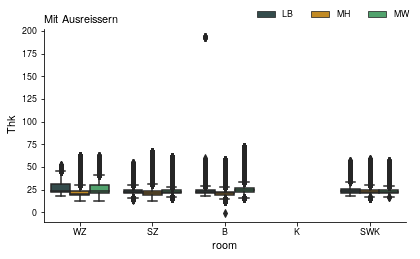

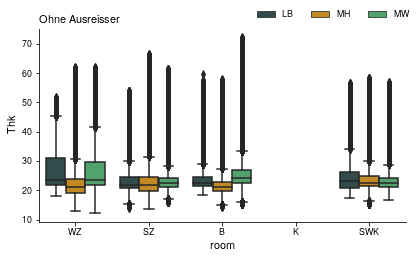

In [10]:
fig, ax = plt.subplots()
THK = IND[IND.columns[IND.columns.get_level_values(3).str.contains('pt_Thk')]].droplevel(3,axis=1).rename_axis(['bui', 'app', 'room'], axis=1).melt(value_name='Thk')
ax = sns.boxplot(data=THK, x = 'room', y='Thk', hue='bui', order=ROOMS, hue_order=BUID, palette=style.CLRS)
ax.set(title='Mit Ausreissern')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

fig, ax = plt.subplots()
ax = sns.boxplot(data=DB.loc[:,IDX[:,:,:,'Thk']].stack([0,1,2]).reset_index(), x = 'room', y='Thk', hue='bui', order=ROOMS, hue_order=BUID, palette=style.CLRS)
ax.set(title='Ohne Ausreisser')
ax.get_legend().remove()
fig.legend(ncol=3, bbox_to_anchor=(1,1), loc='upper right')
fig.tight_layout()

## Datenbanken erstellen...

### 1. TinkerForge (Indoor)

1. Lade TinkerForge (Roh-)Datensätze
2. Benenne Fenster lesbarer um
3. sortiere nichtmehr vorhandene Sensoren aus: `(MH, O, SWK, o_tilt), (LB, N, K, w_t_Tair (°C))`
4. Konvertiere Werte in Kelvin zu Fahrenheit
5. Sortiere (numerische) Sensoren aus, deren Standardabweichung des Messwertes 24h lang 0 beträgt.
6. 

In [11]:
IND = pp.getIND(True)
IND.head(2)

Aktualisiere Raumklima...                                                                    


LB                      \
                                            DA                       
                                            WE                       
                          Pyrano_Diffuse W/m^2 Pyrano_Direct W/m^2   
Datetime                                                             
2021-02-08 11:00:00+01:00                  NaN                 NaN   
2021-02-08 11:01:00+01:00                  NaN                 NaN   

                                                                          \
                                                                           
                                                                           
                          Pyrano_Global W/m^2 trh1_RH (%) trh1_Tair (°C)   
Datetime                                                                   
2021-02-08 11:00:00+01:00                 NaN         NaN            NaN   
2021-02-08 11:01:00+01:00                 NaN         NaN            NaN   

                                                                     \
                                                                  N   
                                                                  B   
                          trh2_RH (%) trh2_Tair (°C) n_pt_Tair (°C)   
Datetime                                                              
2021-02-08 11:00:00+01:00         NaN            NaN            NaN   
2021-02-08 11:01:00+01:00         NaN            NaN            NaN   

                                                      ...         MW  \
                                                      ...          S   
                                                      ...         WE   
                          n_pt_Thk (°C) n_trh_RH (%)  ... E-Pow3 (W)   
Datetime                                              ...              
2021-02-08 11:00:00+01:00           NaN          NaN  ...        NaN   
2021-02-08 11:01:00+01:00           NaN          NaN  ...        NaN   

                                                                         \
                                                                          
                                    WZ                                    
                          n_trh_RH (%) n_trh_Tair (°C) Fenster Ost [XL]   
Datetime                                                                  
2021-02-08 11:00:00+01:00          NaN             NaN              NaN   
2021-02-08 11:01:00+01:00          NaN             NaN              NaN   

                                                                          \
                                                                           
                                                                           
                          pt_Tsk (°C) s_md (0=No, 1=Yes) Fenster Süd [M]   
Datetime                                                                   
2021-02-08 11:00:00+01:00         NaN                NaN             NaN   
2021-02-08 11:01:00+01:00         NaN                NaN             NaN   

                                                                      
                                                  TH                  
                                                  WE                  
                          w_pt_Thk (°C) m_trh_RH (%) m_trh_Tair (°C)  
Datetime                                                              
2021-02-08 11:00:00+01:00           NaN          NaN             NaN  
2021-02-08 11:01:00+01:00           NaN          NaN             NaN  

[2 rows x 323 columns]

### 2. TinkerForge (Outdoor)

1. Lade TinkerForge (roh-) Datenbank
   1. Setze Zeitzone
   2. Behalte Messwerte:
`  ['ID', 'T_amb', 'Rh_amb','windspeed','gustspeed','rain','winddir','btry']`
2. Lade Pyranometer
   1. Korrigiere falsche Direktstrahlung und daraus resultierende Diffusestrahlung.
      1. Ersetze negative Werte der Direktstralung mit 0
      2. Berechne die Diffusstrahlung neu:
         $r_{diff} = r_{global} - r_{direct}$
3. exportiere Datenbank als .pickle Datei

In [12]:
AMB = pp.getAMB(True)
AMB.head(2)

Aktualisiere WetterDB...                                                              


,T_amb,Rh_amb,windspeed,gustspeed,rain,winddir,global,direct,diffuse
Datetime,,,,,,,,,
2021-03-08 11:18:00+01:00,5.0,56.0,0.6,1.0,225.3,SW,0.24,0.0,0.24
2021-03-08 11:19:00+01:00,5.1,56.0,1.3,1.7,225.3,S,0.24,0.0,0.24


### 3. Gesamtdatenbank
Erstelle eine neue Datenbank aus den Rohdaten. Dabei wird das komplette Pre-processing durchgeführt.
Es werden:
1. Fensteröffnungen
   1.  Extrahiere die Fensterinteraktionen (Öffnen (1) /Schließen (-1))
   2.  Gruppiere die Fenstersignale nach Raum
2. Bestimme die Anwesenheit pro Wohnheit
   1. Summe der Kriterien:
   -  Bewegungsmelder
      - Wenn der Bewegungsmelder anschlägt wird 15min vorher und 15min danach Anwesenheit angenommen.
   -  CO2-Konzentration (Sensor im Schlafzimmer als Referenz für die gesamte Wohnung)
      - (A) Wenn die CO2 Konzantration steigt, wird Anwesenheit angenommen (`CO2_A`).
      - (B) Die CO2- Konzentration ist bei geschlossenen Fenstern mehr als 10% über der ref. Konzentration im unbewohnten Appartment (`CO2_B`).
      - (C) Wenn Fenster geöffnet: Wenn solange der 15min gleitende Mittelwert größer als das Tagesmittel ist, wird Anwesenheit angenommen (relevant für Sommerfall bei geöffneten Fenstern) (`co2_B`)
    - absoulte Luftfeuchte:
      - Berechne das quadratische Mittel der Abweichung zwischen den Messwerten in allen Räumen, Wenn dieser Wert > 0 ist, gibt es einen externen Feuchteanstieg im Raum, was ebenfalls als Anwesenheit angenommen wird.
    - Fensteröffnung:
      - Bei einer Fensterinteratktion wird 15min vorher und 15min nachher Anwesenheit angenommen
    - 
3. Extrahiere Messwerte aus den TinkerForge Datenbanken
   1. Wärmemengenzähler
   2. Temperaturen
   3. Luftfeuchten
   4. CO2-Konzentration
   5. Außenklima (Temp, Rh, windspeed, global)
4. Berechne die operative Temperatur aus der Schwarzkugeltemperatur
5. Berechne die absoulte Luftfeuchte aus der Lufttemperatur und rel. Feuchte
6. Bestimme die Heizkörperklassifikation
7. Entferne Unbewohnte Zeiträume


Für die eigentliche Datenbank (getDB) dauert der Vorgang etwa 8min. Die Datenbank mit den Lüftungsvorgängen muss im Anschluss ebenfalls aktualisiert werden.

*Achtung!* 

Wenn neue Datensätze vorhanden sind, müssen vor der aktualisierung der Datenbank erst die Tinkerforge Datensätze (IND & AMB) aktualisiert werden.

In [2]:
DB = pp.getDB(True, correction='lin')
DB.head()

Aktualisiere Datenbank...
#1/9: Leichtbeton Nord
|----> Fertig! Dauer: 62 sec.                                                                                                              
#2/9: Leichtbeton Ost
|----> Fertig! Dauer: 18 sec.                                                                                                              
#3/9: Leichtbeton Süd
|----> Fertig! Dauer: 39 sec.                                                                                                              
#4/9: Massivholz Nord
|----> Fertig! Dauer: 35 sec.                                                                                                              
#5/9: Massivholz Ost
|----> Fertig! Dauer: 19 sec.                                                                                                              
#6/9: Massivholz Süd
|----> Fertig! Dauer: 40 sec.                                                                                                              
#7/

bui                          LB                                           \
app                           N                                            
room                          B                                            
value                     HK_IO  Rh Rh_amb T_amb T_amb_g24 Tair Thk Tset   
Datetime                                                                   
2021-02-08 11:00:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:01:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:02:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:03:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   
2021-02-08 11:04:00+01:00   NaN NaN    NaN   NaN       NaN  NaN NaN  NaN   

bui                                      ...  MW                              \
app                                      ...   S                               
room                                  K  ...  WZ                               
value                     g_abs Fenster  ...  Rh Rh_amb T_amb T_amb_g24 Tair   
Datetime                                 ...                                   
2021-02-08 11:00:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:01:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:02:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:03:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   
2021-02-08 11:04:00+01:00   NaN     NaN  ... NaN    NaN   NaN       NaN  NaN   

bui                                               
app                                               
room                                              
value                     Thk Top Tset Tsk g_abs  
Datetime                                          
2021-02-08 11:00:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:01:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:02:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:03:00+01:00 NaN NaN  NaN NaN   NaN  
2021-02-08 11:04:00+01:00 NaN NaN  NaN NaN   NaN  

[5 rows x 408 columns]

### 4. Lüftungen

In [3]:
LüftungsDB = pp.createLüftungsDB(True)

Aktualisiere LüftungsDB...


# Demonstation des Pre-Processings

## Heizkörper

Das Heizverhalten wird im Messprojekt über einen Oberflächentemperatursensor auf den Heizkörpern überwacht. Aus diesen Temperaturdaten wird abgeleitet, wann ein Heizkörper AN oder AUS sein muss. Dazu wird die Oberflächentemperatur des Heizkörpers in relation zur Lufttemperatur gesetzt.

Lade Raumklima...


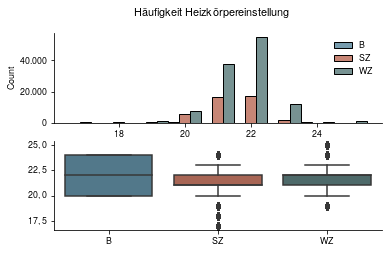

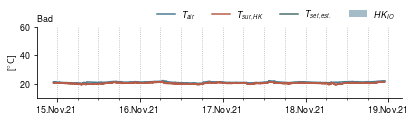

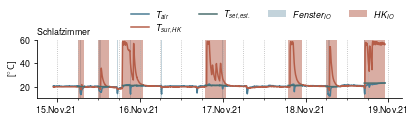

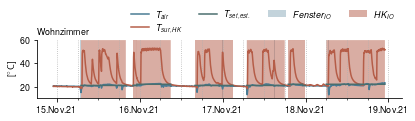

In [7]:
_hk = pp.getHKIO('MH', 'S', plot=True, start='2021-11-15', end='2021-11-18', export=True)

### Auswertung der Klassifikation // Bestimmung von Tset

Ergebnis:
- Einige Ausreiser im Sommer; erstmal quantile aussortieren und dann Treshhold im Preprocessing anpassen.

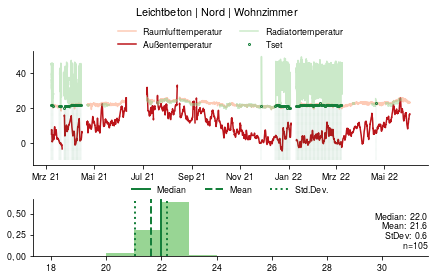

In [3]:
for bui in BUID:
    for app in APPS:
        for room in ROOMS:
            try:
                df = DB[bui][app][room]
                if not all([x in df.columns for x in ['Thk', 'Tset']]):
                    continue
            except KeyError:
                continue
            fig, axs = plt.subplots(2, 1, sharey='row', sharex='row', gridspec_kw={
                                    'height_ratios': [2, 1]})
            fig.suptitle(f'{BUID[bui]} | {APPS[app]} | {ROOMS[room]}', y=1.02)
            ax = axs[0]
            ax.plot(df['Tair'].resample('H').mean(),
                    label='Raumlufttemperatur', c=plt.cm.Reds(0.2))
            ax.plot(df['T_amb'].rolling('D').mean(),
                    c=plt.cm.Reds(0.8), label='Außentemperatur')

            ax.plot(df['Thk'], c=plt.cm.Greens(0.4),
                    alpha=0.5, label='Radiatortemperatur')
            ax.plot(df['Tset'].resample('D').median(), linestyle='None', marker='o',
                    mfc='None', markersize=2, c=plt.cm.Greens(0.8), label='Tset')

            ax.vlines(df['Tset'].resample('D').median().index, ymin=-10, ymax=df['Tset'].resample(
                'D').median(), linestyles='dashed', linewidth=.1, colors=plt.cm.Greens(0.8))

            ax.legend(ncol=2, bbox_to_anchor=(0.5, .95),loc='lower center', frameon=False)

            ax2 = axs[1]

            bins = np.arange(18, 32, 1)

            ax2.hist(df['Tset'], density=True,
                     bins=bins, color=mpl.cm.Greens(0.4))

            _mean = df['Tset'].mean()
            _median = df['Tset'].median()
            _std = df['Tset'].std()

            ax2.axvline(_median, c=mpl.cm.Greens(
                0.8), linewidth=2, label='Median')
            ax2.axvline(_mean, c=mpl.cm.Greens(0.8), linewidth=2,
                        linestyle='dashed', label='Mean')
            ax2.axvline(_mean - _std, c=mpl.cm.Greens(0.8),
                        linewidth=2, linestyle='dotted', label='Std.Dev.')
            ax2.axvline(_mean + _std, c=mpl.cm.Greens(0.8),
                        linewidth=2, linestyle='dotted')
            ax2.legend(ncol=3, bbox_to_anchor=(.5, .95), loc='lower center', frameon=False)

            ax2.text(1, 0.1, f"Median: {df['Tset'].median():.1f}\nMean: {df['Tset'].mean():.1f}\nStDev: {df['Tset'].std():.1f}\nn={df['HK_IO'].resample('D').max().sum():.0f}",
                     transform=ax2.transAxes, ha='right', va='bottom')
            fig.tight_layout(pad=0.1)
            break
        break
    break

# Klassifikation Anwesenheit

Lade Raumklima...


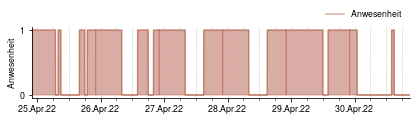

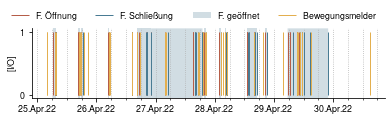

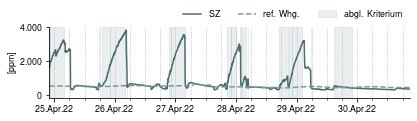

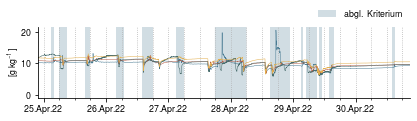

In [5]:
bui = 'LB'
app = 'S'
date = IDX['2022-04-25':'2022-04-30']

data = pp.getAnwesenheit(bui, app, date=date, plot=True, export=True)

# Bestimme Heiztage

In [13]:
from sklearn.cluster import KMeans
from src.preprocessing import getData, removeUnoccupied

In [14]:
data = removeUnoccupied(getData(value='HK_IO', app=['N', 'S'])).groupby(level=[0,1,2],axis=1).median().resample('H').mean().resample('D').mean()
df = data.rolling('3D', center=True).mean().round(2)
dfs = []
for (bui, app, room), group in df.groupby(level=[0,1,2], axis=1):
    mydata = group[bui, app, room].dropna()
    cluster_id = KMeans(2).fit_predict(mydata.values.reshape(-1,1))
    cluster_means = pd.Series({ii: mydata[cluster_id==ii].mean() for ii in np.unique(cluster_id)})
    status = {cluster_means.idxmax(): True, cluster_means.idxmin(): False}
    dfs.append(pd.Series(cluster_id, index=mydata.index).replace(status).rename((bui, app, room, 'HK_IO')))
removeUnoccupied(pd.concat(dfs, axis=1)).reindex(getData(value='HK_IO', app=['N', 'S']).index, method='ffill').where(getData(value='HK_IO', app=['N', 'S']).notna())

Lade WetterDB...
Lade Raumklima...
Lade gespeicherte Datenbank...                                                                


LB                                  MH        \
                              N                 S                 N         
                              B    SZ    WZ     B    SZ    WZ     B    SZ   
                          HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO   
Datetime                                                                    
2021-02-08 11:00:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:01:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:02:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:03:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:04:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
2022-06-02 01:56:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-06-02 01:57:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-06-02 01:58:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-06-02 01:59:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-06-02 02:00:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                                                     MW                    \
                                    S                 N                 S   
                             WZ     B    SZ    WZ     B    SZ    WZ     B   
                          HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO HK_IO   
Datetime                                                                    
2021-02-08 11:00:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:01:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:02:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:03:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2021-02-08 11:04:00+01:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
...                         ...   ...   ...   ...   ...   ...   ...   ...   
2022-06-02 01:56:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-06-02 01:57:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-06-02 01:58:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-06-02 01:59:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2022-06-02 02:00:00+02:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

                                       
                                       
                             SZ    WZ  
                          HK_IO HK_IO  
Datetime                               
2021-02-08 11:00:00+01:00   NaN   NaN  
2021-02-08 11:01:00+01:00   NaN   NaN  
2021-02-08 11:02:00+01:00   NaN   NaN  
2021-02-08 11:03:00+01:00   NaN   NaN  
2021-02-08 11:04:00+01:00   NaN   NaN  
...                         ...   ...  
2022-06-02 01:56:00+02:00   NaN   NaN  
2022-06-02 01:57:00+02:00   NaN   NaN  
2022-06-02 01:58:00+02:00   NaN   NaN  
2022-06-02 01:59:00+02:00   NaN   NaN  
2022-06-02 02:00:00+02:00   NaN   NaN  

[689161 rows x 18 columns]

In [15]:
ref_prof = pp.getHeiztage()
data = removeUnoccupied(getData(value='HK_IO', app=['N', 'S'], room=['SZ', 'WZ'])).groupby(level=[0,1,2],axis=1).median().resample('H').mean().resample('D').mean()
df = data.rolling('3D', center=True).mean().round(2)
mydata = df.stack([0,1,2]).dropna()
cluster_id = KMeans(2).fit_predict(mydata.values.reshape(-1,1))
cluster_means = pd.Series({ii: mydata[cluster_id==ii].mean() for ii in np.unique(cluster_id)})
status = {cluster_means.idxmax(): True, cluster_means.idxmin(): False}
tags = {False: {'label':'Heizung AUS', 'color':style.clrs[1]}, True: {'label':'Heizung AN', 'color':style.clrs[0]}}
sig = pd.Series(cluster_id, index=mydata.index).map(status).rename('Heizung AN')

Lade WetterDB...
Lade Raumklima...
Lade gespeicherte Datenbank...                                                                


exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...
exportiere die zuletzt verwendete Figure...


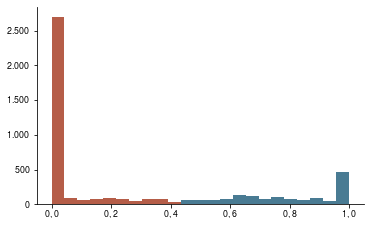

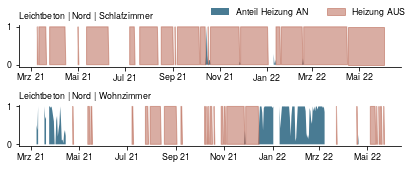

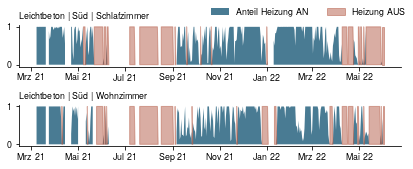

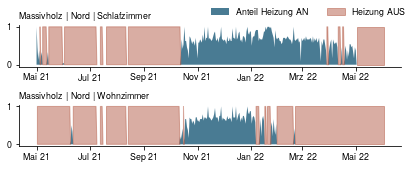

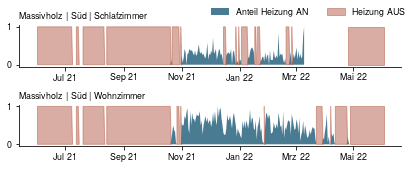

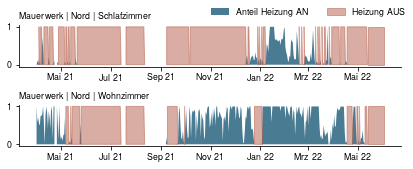

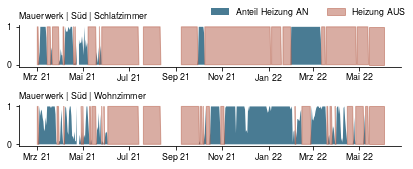

In [16]:
bins = np.linspace(mydata.min(), mydata.max(), 24)
for ii, stat in status.items():
    subset = mydata[cluster_id==ii]
    plt.hist(subset, bins=bins, **tags[stat])

ANW = pd.concat([data, sig.unstack(['bui', 'app', 'room']).sort_index()], keys=['Heizung AN', 'Heizung AUS'], axis=1).reorder_levels([1,2,3,0], axis=1).sort_index(axis=1)
for (bui, app), group in ANW.groupby(level=[0,1], axis=1):
    fig, axs = plt.subplots(2,1, **style.size(aspect=0.4))
    for r, (col, roomdata) in enumerate(group.groupby(level=[0,1,2], axis=1)):
        df = roomdata[col]
        axs[r].fill_between(x=df.index, y1=df['Heizung AN'], alpha=1, label='Anteil Heizung AN')
        axs[r].fill_between(x=df.index, y1=0, y2=1, where=(df['Heizung AN']==0) & (df['Heizung AN'].notna()).where(ref_prof[col].squeeze()==0), color=style.red, alpha=0.5, label='Heizung AUS', interpolate=True)
        #axs[r].fill_between(x=df.index, y1=0, y2=1, where=df['Heizung AN'].isna(), color='k', alpha=0.25, label='NA', transform=ax.get_xaxis_transform())
        axs[r].set_title(f'{style.NAMES[bui]} | {style.NAMES[app]} | {style.NAMES[col[2]]}')
    style.uniqueLegend(axs, fig, ncol=3)
    fig.tight_layout()
    style.toTex('appendix', f'ClusterHeizung_{bui}_{app}')

# Suche zusammenhängende Zeiträume mit Abwesenheit (Urlaub)

exportiere die zuletzt verwendete Figure...


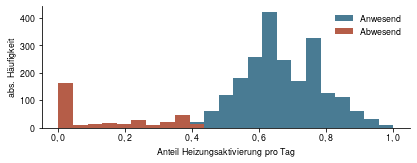

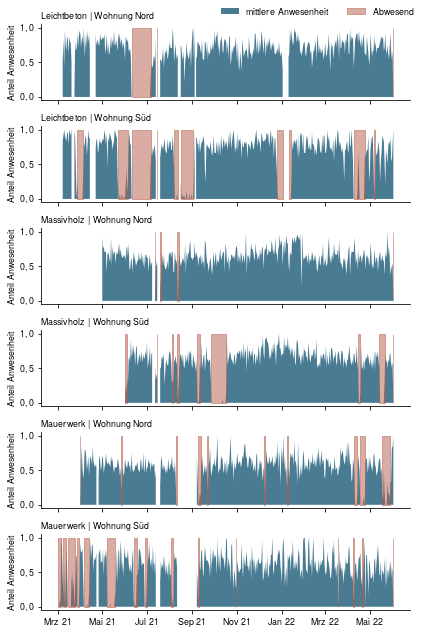

In [13]:
sig = pp.removeHolidays('filter', plot=True)
style.toTex('appendix', 'AnwesenheitsCluster')

# Klassifikation Lüftung

- ToDo: Graph aufhübschen und beschriften

In [22]:
from src.templates import plotLüftung

Lade gespeicherte LüftungsDB...
Extrahiere Lüftungen...
Dauer 0 days 02:23:00, Temperaturpotential nan                                                                                                    
Abkühlzeit: 0 days 02:00:00
Abkühlzeit: 0 days 02:00:00
delta T: -6.6 K
Die Raumtemperatur steigt bereits bei geöffnetem Fenster.
Aufwärmzeit (Fenster offen): 0 days 00:23:00
Aufwärmzeit (Fenster geschlossen): 0 days 22:12:00
delta T: 6.4 K


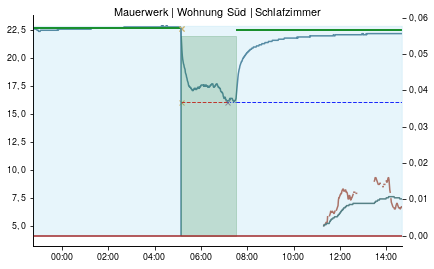

In [23]:
room = 'SZ'
plotLüftung(bui, app, room)

# Näherungsweise Bestimmung der operativen Temperatur

Lade WetterDB...
Lade Raumklima...
Lade gespeicherte Datenbank...                                                                
Ermittleter Faktor:                                                                         
 [[0.96947441]]
Mittleres Residuenquadrat: 0.09
$R^2$: 0.94
Ermittleter Faktor: 
 [[0.98014337]]
Mittleres Residuenquadrat: 0.16
$R^2$: 0.95
Ermittleter Faktor: 
 [[0.98949737]]
Mittleres Residuenquadrat: 0.25
$R^2$: 0.83


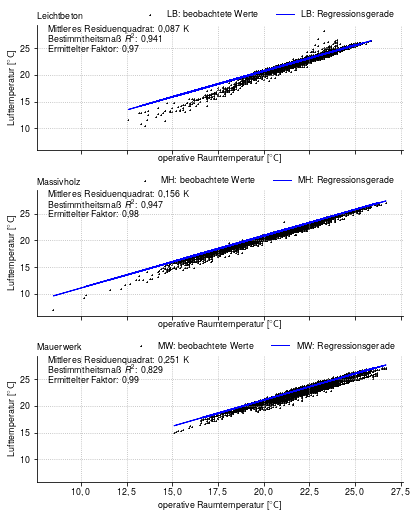

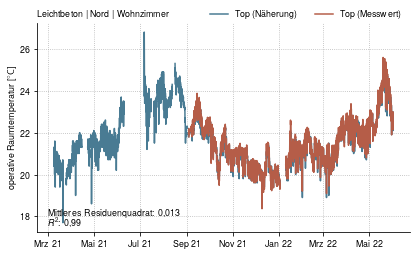

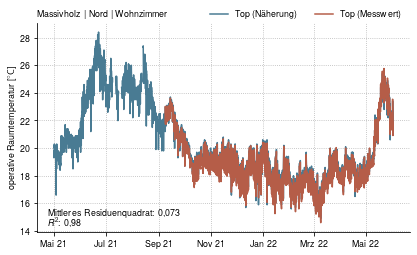

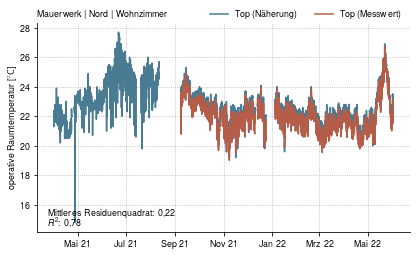

In [3]:
from sklearn.metrics import mean_squared_error, r2_score

df = pp.estimateOperativeTemperature(mode='linear', plot=True, export=False)
bui, app, room = 'LB', 'N', 'WZ'
for bui in BUID:
    est = df[(bui, app, room)]
    obs = getData(bui = bui, app = app, room = room, value = 'Top').resample('H').mean()
    fig, ax = plt.subplots()
    ax.plot(est, label=r'Top (Näherung)')
    ax.plot(obs, label=r'Top (Messwert)')
    ax.set_title(f'{BUID[bui]} | {APPS[app]} | {ROOMS[room]}')
    ax.legend(ncol=2, frameon=False, bbox_to_anchor = (1, .98), loc='lower right')
    ax.set_ylabel(r'operative Raumtemperatur $[\si{\celsius}]$')
    ax.grid()
    text = '\n'.join([
        f"Mittleres Residuenquadrat: {mean_squared_error(*est.join(obs, lsuffix='pred', rsuffix='obs').dropna().to_numpy().T):.2n}", 
        f"$R^2$: {r2_score(*est.join(obs, lsuffix='pred', rsuffix='obs').dropna().to_numpy().T):.2n}"])

    ax.text(0.03,0.03, text, transform=ax.transAxes, ha='left')
    fig.tight_layout()

# Fehlende Datensätze

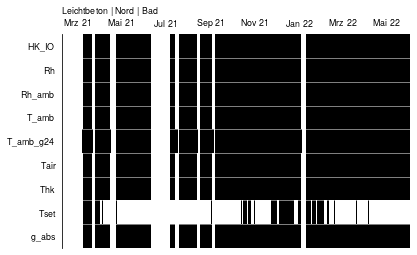

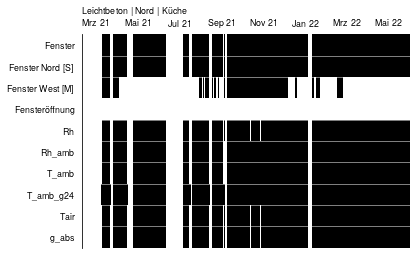

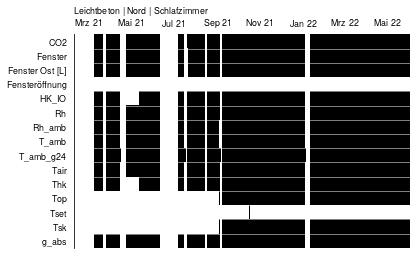

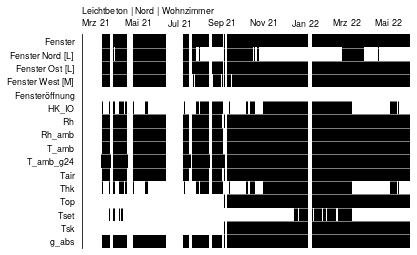

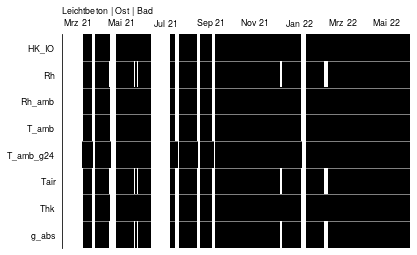

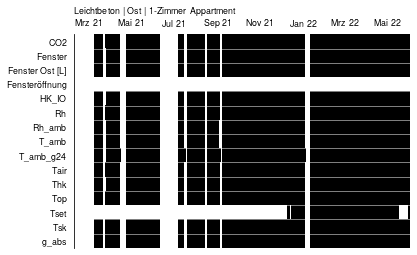

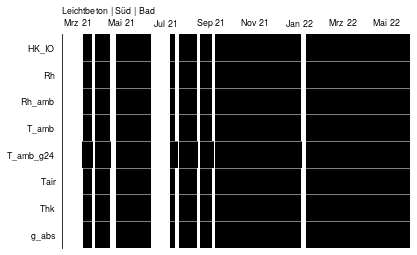

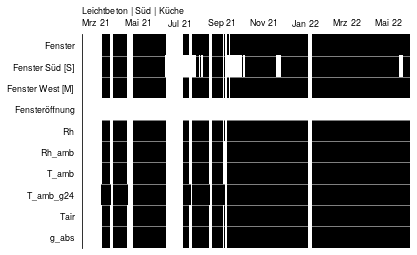

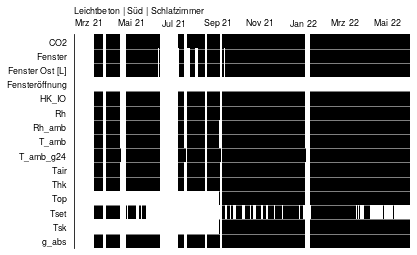

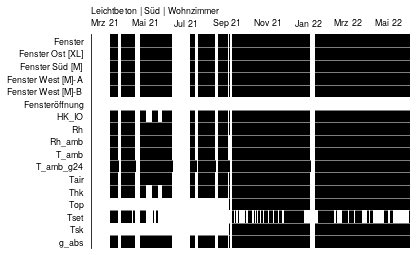

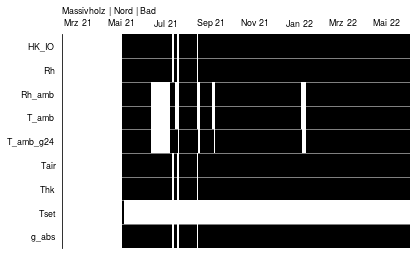

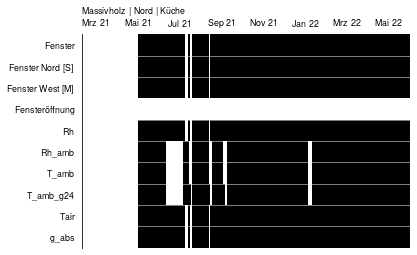

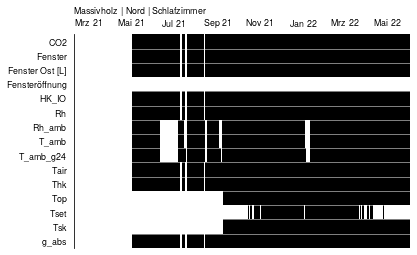

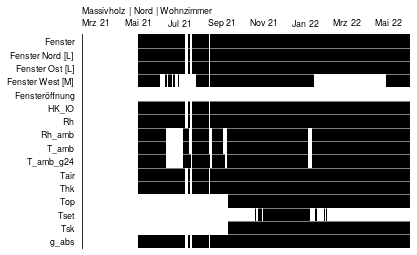

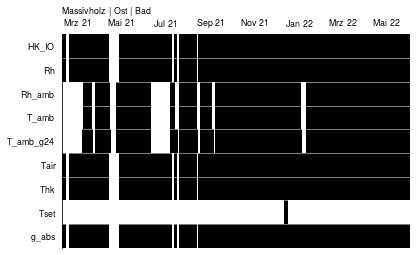

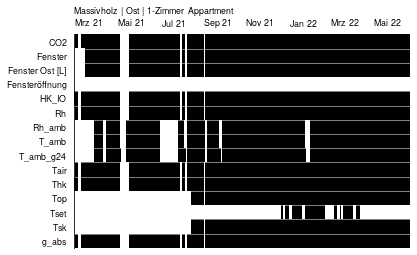

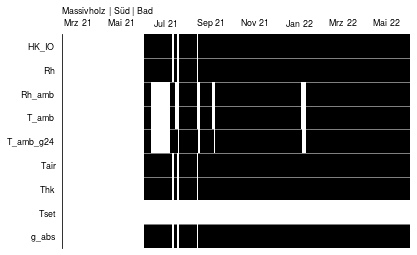

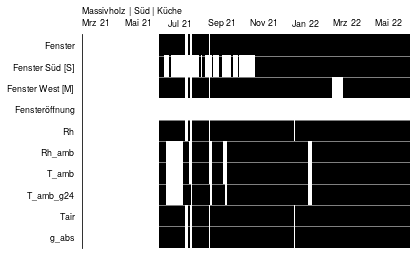

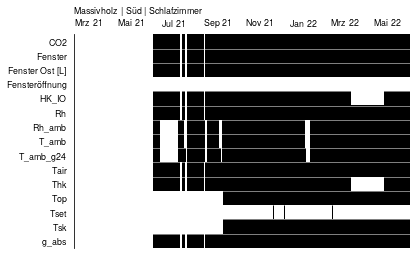

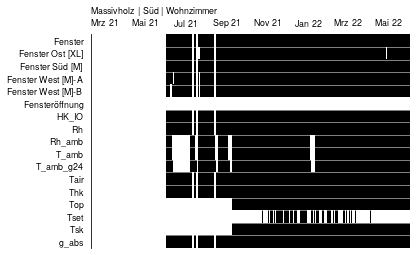

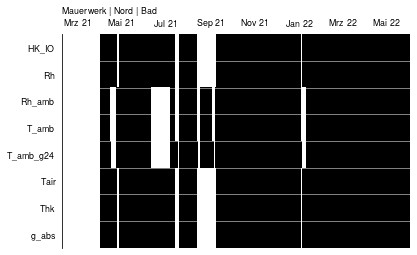

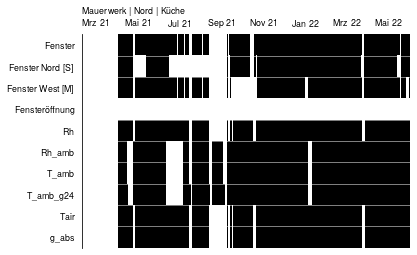

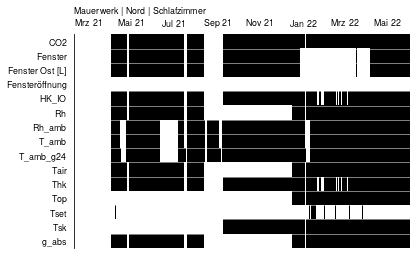

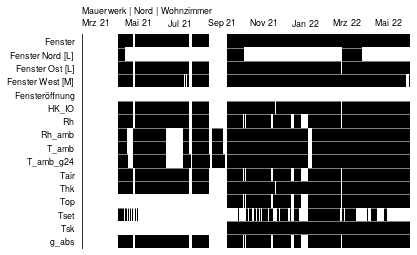

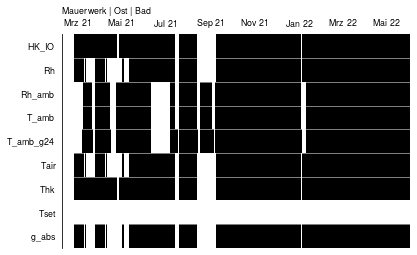

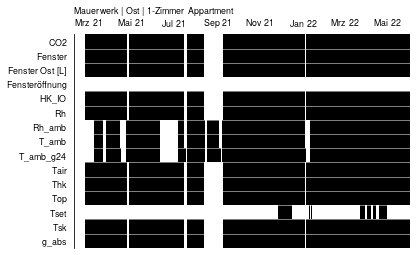

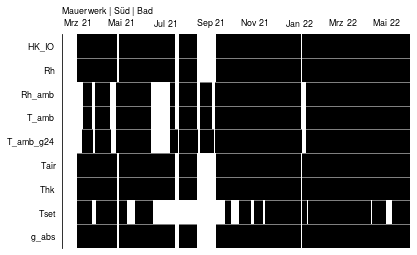

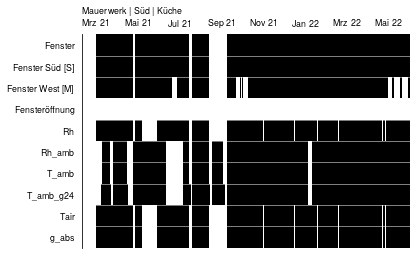

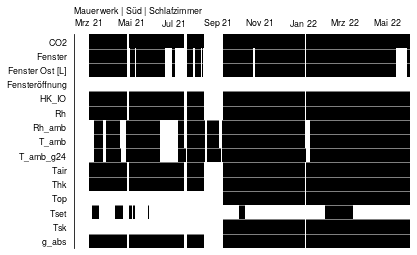

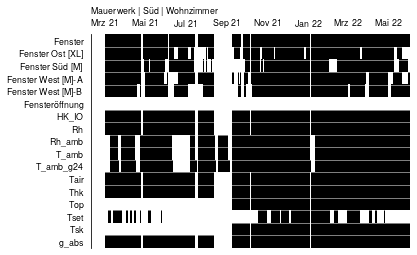

In [18]:
cmap = mpl.colors.ListedColormap(["w", "k"])
for (bui, app, room), data in DB.groupby(level=[0,1,2], axis=1):
    try:
        pp.plotMissingData(data, level=3, title=f'{BUID[bui]} | {APPS[app]} | {ROOMS[room]}', cmap=cmap, ori='v')
    except KeyError:
        pass